In [1]:
%matplotlib inline

# Training Conv Nets and visualizing their activations

In this example, we do the following things:
1. Define a Convolutional Neural Network (CNN)
2. Define a loss function and an optimizer
3. Load and normalize the MNIST data set, an example for handwritten digit recognition
4. Train the network from scratch
5. Evaluate the network on test data
6. Visualize the activations of the networks layers 


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F

## Define a Convolutional Neural Network
We start of by definining the structure of a symple conv net that we want to use in the following. For this, we employ modules from `torch.nn` which we have imported as `nn`.

In [3]:
class Net(nn.Module):
    def __init__(self):
        # In the constructor, we first call the constructor
        # for a general neural network module
        super(Net, self).__init__()
        # define the layers of the network
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        # define the forward pass of the network
        # the backward pass can then be done automatically
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def num_flat_features(self, x):
        # computes the number of dimensions for the flattening step
        # from a conv layer to a fully connected one
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward_until(self, x, l):
        # This function is utilized for visualizing layer activations 
        x = self.pool(F.relu(self.conv1(x)))
        if l == 1:
            return x
        x = self.pool(F.relu(self.conv2(x)))
        if l == 2:
            return x
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        if l == 3:
            return x
        x = self.fc2(x) 
        return x
    
    
# initialize the network
net = Net()

## Define the loss function, the optimizer and its parameters

In [4]:
import torch.optim as optim

# The Cross Entropy Loss is most common for classification
criterion = nn.CrossEntropyLoss()

# Parameters for the optimizier, in this case stochastic gradient descent
learning_rate = 0.001
momentum_term = 0.9
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum_term)
#optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

## Load the MNIST Data

The MNIST data set is a popular benchmark data set in deep learning. It consists of images of handwritten digits of size [28, 28]. These are cropped, centered and given by a single channel. The ten classes are 0 ... 9 and there are 60.000 training images and 10.000 images for testing.

We can load this data set (as well as many others) comfortably using `torchvision`. It downloads the data set the first time, and then utilizes the stored data.
The images are by default stored as PIL images in range [0,1]. We convert them to pytorch tensors and transform them to [-1.1].

In [5]:
import torchvision
from torchvision import datasets, transforms

# define a normalization function in order to apply it later on to the training and test set
transform=transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_s_tr = 64
batch_s_te = 1000

train_set = datasets.MNIST('./data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_s_tr, shuffle=True)

test_set = datasets.MNIST('./data/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_s_te, shuffle=True)


Show a few example images and their according labels

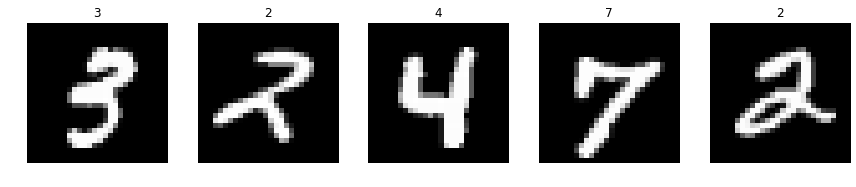

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show some images
num_disp = 5
fig, axes = plt.subplots(1,num_disp, figsize=(12, 8))
for i in range(0, num_disp):
    axes[i].imshow((images[i,0,:,:]/2 + 0.5).numpy(), cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')
    axes[i].set_title(labels[i].item())
    
plt.tight_layout()
plt.show()

## Train the Convolutional Network

Can be called multiple times to iterate repeatedly over the trainings set. Alternatively, the variable `n_epochs` can be adjusted.


In [7]:
%%time
net.train() # set the net in training mode
n_epochs = 1
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99: # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_s_tr*i, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,  6336] loss: 2.257
[1, 12736] loss: 1.999
[1, 19136] loss: 1.137
[1, 25536] loss: 0.564
[1, 31936] loss: 0.420
[1, 38336] loss: 0.375
[1, 44736] loss: 0.341
[1, 51136] loss: 0.302
[1, 57536] loss: 0.266
Finished Training
CPU times: user 3min 55s, sys: 6min 25s, total: 10min 21s
Wall time: 1min 18s


Test the trained model for a few examples and display the ground truth (GT) and the predicted value.

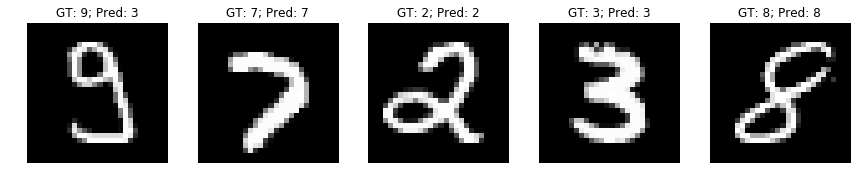

In [8]:
# iterate over the test set
dataiter = iter(test_loader)
images, labels = dataiter.next()

num_disp = 5
# perform a prediction for a few examples
net.eval() # set the net in prediction mode
with torch.no_grad(): # don't keep track of gradients
    # output contains certainties for each class
    outputs = net(images[0:num_disp,:,:,:])
# get the index of the highest certainty for each point
_, predicted = torch.max(outputs.data, 1)


fig, axes = plt.subplots(1,num_disp, figsize=(12, 8)) # , sharex=True, sharey=True)
for i in range(0, num_disp):
    axes[i].imshow((images[i,0,:,:]/2 + 0.5).numpy(), cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')
    axes[i].set_title("GT: " + str(labels[i].item()) + "; Pred: " + str(predicted[i].item()))

plt.tight_layout()
plt.show()

## Test the trained model

Perform a proper evaluation on a held out test set and compute the error for the whole set

In [9]:
net.eval() # set the net to eval mode
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (
    total, 100 * correct / total))

Accuracy of the network on the 10000 test images: 93 %


## Visualize the activations of the hidden layers



torch.Size([1000, 20, 12, 12])
torch.Size([1000, 50, 4, 4])
torch.Size([1000, 500])
torch.Size([1000, 10])


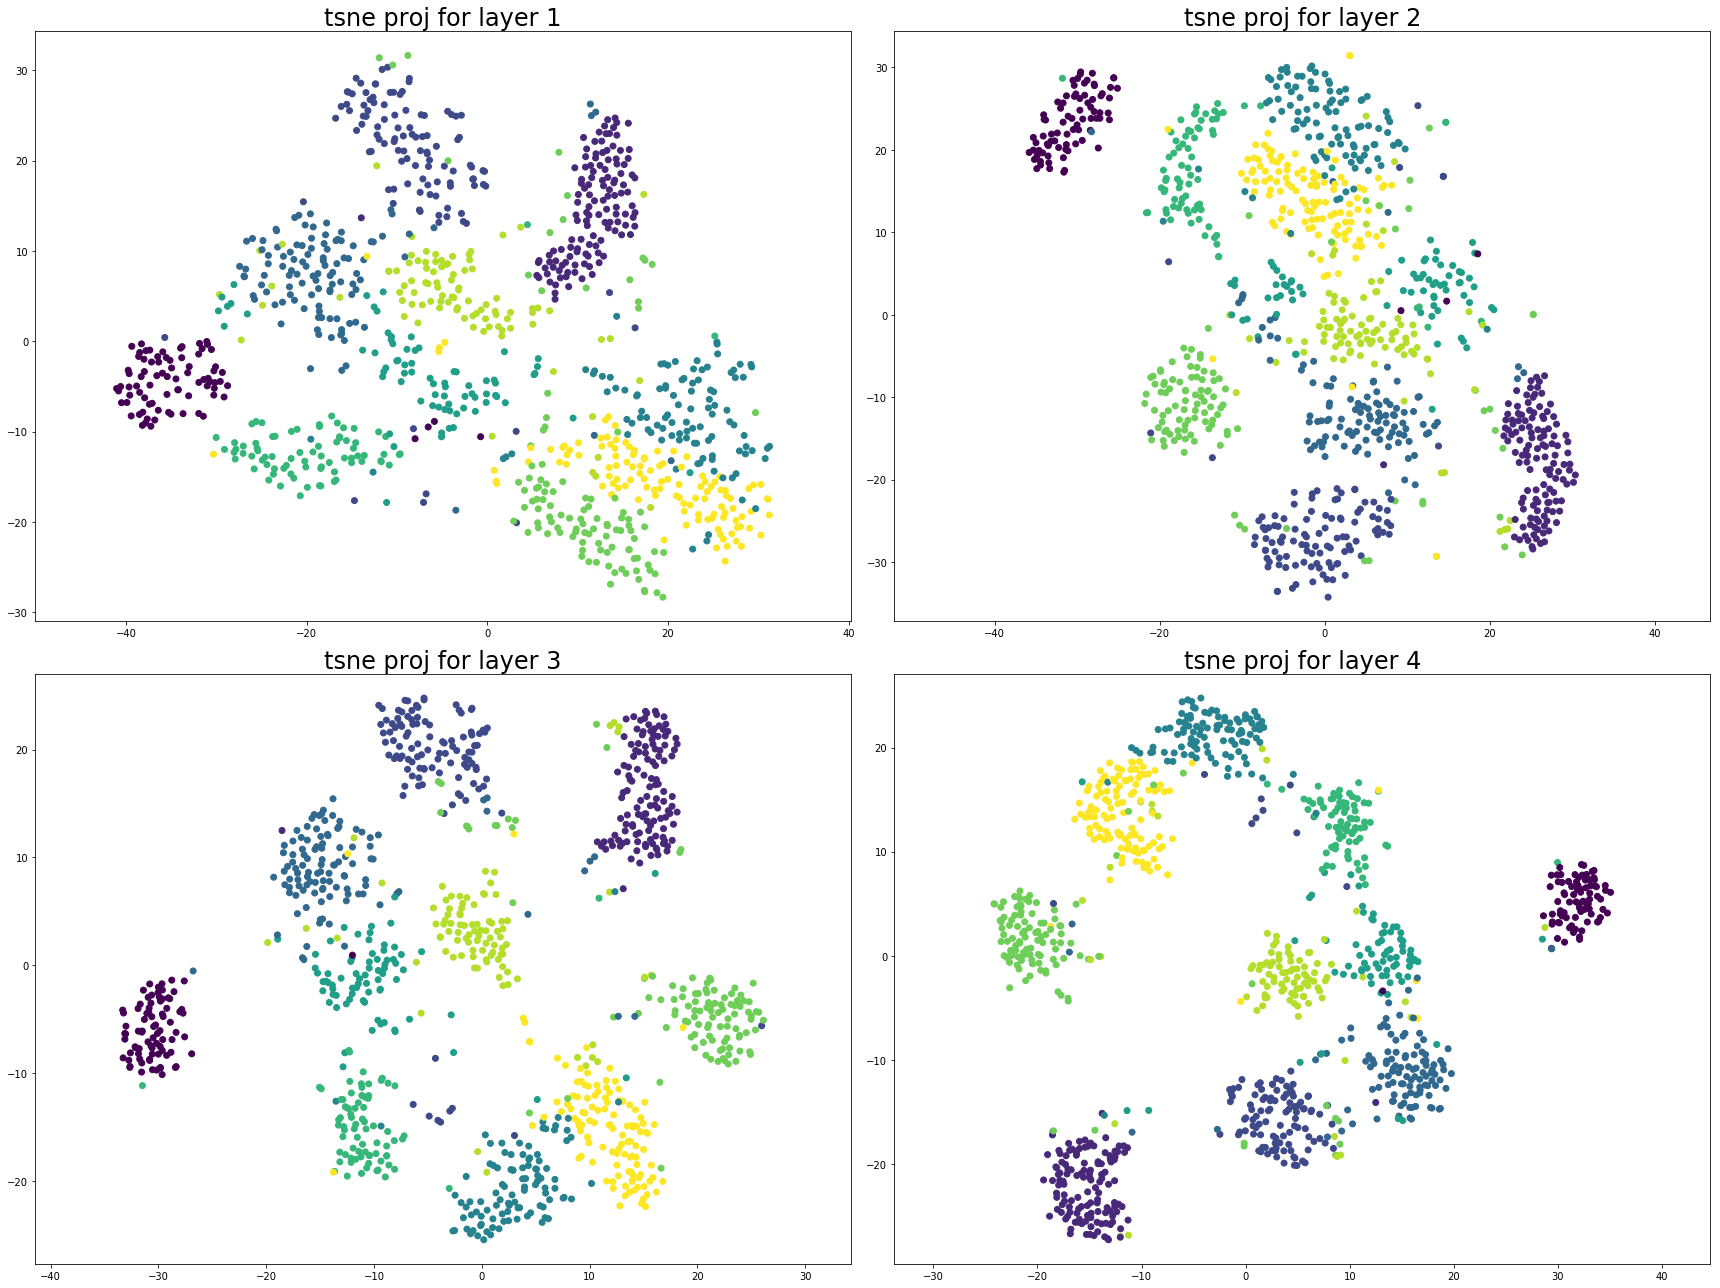

In [16]:
import sklearn.manifold as mf
import sklearn.decomposition as dec
# compute a projection of the intermediate layers

num_iter = 1 # number point is then * 1000 (=batch_s_te)
X = torch.zeros([batch_s_te*num_iter, 1, 28, 28])
labels = np.zeros([batch_s_te*num_iter])
# store a few test data
for i, data in enumerate(test_loader):
    if i == num_iter:
        break
    images, labs = data
    X[i*batch_s_te:i*batch_s_te+batch_s_te,:,:,:] = images
    labels[i*batch_s_te:i*batch_s_te+batch_s_te] = labs.numpy()
    
    
    
num_projs = 4
data_proj = np.zeros([num_projs, num_iter*batch_s_te, 2])

plt.figure(figsize=(24, 18))
for p in range(1, num_projs+1):
    plt.subplot(2,2,p)
    with torch.no_grad():
        # calculate the activations of layer p for the given data
        layer_out = net.forward_until(X, p)
    print(layer_out.size())

    # compute a projection of these activations to two dimensions
    pca_proj = dec.PCA(min(100, np.prod(layer_out.numpy().shape[1:]))).fit_transform(
        layer_out.numpy().reshape([num_iter*batch_s_te, -1]))
    data_proj[p-1, :, :] = mf.TSNE(2, perplexity=50).fit_transform(pca_proj)

    # plot the 2D projections
    plt.scatter(data_proj[p-1, :, 0], data_proj[p-1, :, 1], c=labels)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('tsne proj for layer ' + str(p), fontsize=24);

plt.tight_layout()
plt.show()